In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/RecSysCuratorNet/HERE

/content/drive/MyDrive/RecSysCuratorNet/HERE


In [3]:
import os
import torch
import numpy as np
import pandas as pd
from skimage import io
from tqdm.auto import tqdm
import numpy as np

from models import VBPR, DVBPR, ACF, CuratorNet
from datasets.user_mode_img import ToTensor
from utils.data import extract_embedding
from utils.metrics import (
    auc_exact,
    nDCG,
    precision,
    recall,
    reciprocal_rank,
)

# Evaluation procedure

In [4]:
DATASET = "Ugallery"

# Model
MODEL = "CuratorNet"

FEATURE_EXTRACTOR = "resnet50"
assert FEATURE_EXTRACTOR in ["resnet50",'clip','vit','mae']

FEATURE_LAYER = "layer4"

In [5]:
# Mode
MODE_PROFILE = MODEL in ["CuratorNet"]
MODE_PROFILE = "profile" if MODE_PROFILE else "user"

# Checkpoint (ex. 'VBPR_wikimedia')
CHECKPOINT = f"{MODEL}_ugallery"

In [6]:
# Paths (general)
CHECKPOINT_EXT = "pt" if MODEL == "ACF" else "tar" 
CHECKPOINT_PATH = f'/content/drive/MyDrive/RecSysCuratorNet/HERE/checkpoints/checkpoints_{FEATURE_EXTRACTOR}/CuratorNet_ugallery.tar'
#FEATURE_EXTRACTOR = f"{FEATURE_EXTRACTOR}-{FEATURE_LAYER}" if FEATURE_LAYER else FEATURE_EXTRACTOR
EMBEDDING_PATH = f'/content/drive/MyDrive/RecSysCuratorNet/HERE/embeddings/embeddings_{FEATURE_EXTRACTOR}.npy'
EVALUATION_PATH = os.path.join("data/UGallery", f"naive-{MODE_PROFILE}-evaluation.csv")


# General constants
RNG_SEED = 0
USE_GPU = True

In [7]:
# Freezing RNG seed if needed
if RNG_SEED is not None:
    print(f"\nUsing random seed... ({RNG_SEED})")
    torch.manual_seed(RNG_SEED)


Using random seed... (0)


In [8]:
# Load embedding from file
print(f"\nLoading embedding from file... ({EMBEDDING_PATH})")
embedding = np.load(EMBEDDING_PATH, allow_pickle=True)
#embedding=resnet50
# Extract features and "id2index" mapping
print("\nExtracting data into variables...")
features, id2index, item_index2fn = extract_embedding(embedding, verbose=True)
print(f">> Features shape: {features.shape}")
del embedding  # Release some memory



Loading embedding from file... (/content/drive/MyDrive/RecSysCuratorNet/HERE/embeddings/embeddings_resnet50.npy)

Extracting data into variables...
>> Features shape: (13297, 2048)


In [9]:
string_to_list = lambda s: list(map(int, s.split()))

In [10]:
# Load evaluation dataframe
print("\nLoad evaluation dataframe")
evaluation_df = pd.read_csv(EVALUATION_PATH)
# Transform lists from str to int
string_to_list = lambda s: list(map(int, s.split()))
evaluation_df["profile"] = evaluation_df["profile"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
evaluation_df["predict"] = evaluation_df["predict"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
# Group evaluations by profile and user
evaluation_df["profile"] = evaluation_df["profile"].map(tuple)
evaluation_df = evaluation_df.groupby(["profile", "user_id"]).agg({"predict": sum}).reset_index()
evaluation_df["profile"] = evaluation_df["profile"].map(list)
print(f">> Evaluation: {evaluation_df.shape}")


Load evaluation dataframe
>> Evaluation: (728, 3)


In [11]:
# Create device instance
print("\nDevice initialization")
device = torch.device("cuda:0" if torch.cuda.is_available() and USE_GPU else "cpu")
if torch.cuda.is_available() != USE_GPU:
    print((f"\nNotice: Not using GPU - "
           f"Cuda available ({torch.cuda.is_available()}) "
           f"does not match USE_GPU ({USE_GPU})"
    ))

# Loading checkpoint
if CHECKPOINT is not None:
    print("\nLoading checkpoint")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device("cpu"))
    if 'epoch' in checkpoint and 'accuracy' in checkpoint:
        print(f">> Best epoch: {checkpoint['epoch']} | Best accuracy: {checkpoint['accuracy']}")
    elif 'epoch' in checkpoint and 'loss' in checkpoint:
        print(f">> Best epoch: {checkpoint['epoch']} | Best Loss: {checkpoint['loss']}")

# Model initialization
print("\nModel initialization")
model = None
checkpoint_loaded = False
if MODEL == "VBPR":
    n_users = checkpoint["model"]["gamma_users.weight"].size(0)
    n_items = checkpoint["model"]["gamma_items.weight"].size(0)
    dim_gamma = checkpoint["model"]["gamma_users.weight"].size(1)
    dim_theta = checkpoint["model"]["theta_users.weight"].size(1)
    model = VBPR(
        n_users, n_items,  # Number of users and items
        torch.Tensor(features),  # Pretrained visual features
        dim_gamma, dim_theta,  # Size of internal spaces
    ).to(device)
elif MODEL == "CuratorNet":
    model = CuratorNet(
        torch.Tensor(features),
        input_size=features.shape[1],
    ).to(device)
elif MODEL == "ACF":
    model = ACF.from_checkpoint(checkpoint, device=device)
    checkpoint_loaded = True
elif MODEL == "DVBPR":
    n_users = checkpoint["model"]["theta_users.weight"].size(0)
    n_items = checkpoint["model"]["gamma_items.weight"].size(0)
    K = checkpoint["model"]["theta_users.weight"].size(1)
    model = DVBPR(n_users, n_items, K=K).to(device)
    
# Load state dict
if not checkpoint_loaded and CHECKPOINT is not None:
    model.load_state_dict(checkpoint["model"])
    print('loaded')

# Change model mode to eval
print("\nChanging model mode to eval")
model.eval()


Device initialization

Loading checkpoint
>> Best epoch: 10 | Best accuracy: 0.9887823960101022

Model initialization
loaded

Changing model mode to eval


CuratorNet(
  (embedding): Embedding(13297, 2048)
  (selu_common1): Linear(in_features=2048, out_features=200, bias=True)
  (selu_common2): Linear(in_features=200, out_features=200, bias=True)
  (maxpool): AdaptiveMaxPool2d(output_size=(1, 200))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 200))
  (selu_pu1): Linear(in_features=400, out_features=300, bias=True)
  (selu_pu2): Linear(in_features=300, out_features=300, bias=True)
  (selu_pu3): Linear(in_features=300, out_features=200, bias=True)
)

In [12]:
# Predict all
# If True, ranks every item including already consumed items
# If False, ranks ALL - PROFILE (consumed) + PREDICT (ground truth)
PREDICT_ALL = False

In [13]:
%%time
# Metrics
N_EVALS = len(evaluation_df.index)
# Area Under the Curve (AUC)
AUC = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Reciprocal Rank (RR)
RR = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Recall
R20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
R100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
R200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Precision
P20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
P100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
P200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
# Normalized discounted cumulative gain (nDCG)
N20 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
N100 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
N200 = torch.zeros([N_EVALS], dtype=torch.float64, device=device)
PROFILE_SIZES = torch.zeros([N_EVALS], dtype=int, device=device)
N_ITEMS = len(features)

CPU times: user 1.54 ms, sys: 794 µs, total: 2.34 ms
Wall time: 14 ms


In [14]:
if MODEL in ("VBPR", "CuratorNet"):
    cache = model.generate_cache()
elif MODEL == "DVBPR":
    def getimg(path, tensorizer):
        img = io.imread(path)
        return tensorizer(img)
    
    imglist = {}
    for path in tqdm(os.listdir(IMAGES_DIR)):
        if path in item_index2fn.values():
            img = getimg(os.path.join(IMAGES_DIR, path), ToTensor()) 
            name = path.split('.')[0]
            imglist[id2index[name]] = img

    assert len(imglist) == N_ITEMS
    print('images loaded:', N_ITEMS)
    cache = model.generate_cache(imglist, device=device)
    print('generated cache: ', cache.shape)

In [15]:
evaluation_df["profile"] = evaluation_df["profile"].map(tuple)
grouped_evals = evaluation_df.groupby(["profile", "user_id"]).agg({"predict": sum}).reset_index()
for i, row in tqdm(enumerate(evaluation_df.itertuples()), total=len(evaluation_df.index)):
    # Load data into tensors
    profile = torch.tensor(row.profile).to(device, non_blocking=True).unsqueeze(0)
    user_id = torch.tensor([int(row.user_id)]).to(device, non_blocking=True)
    predict = torch.tensor(row.predict).to(device, non_blocking=True)
    # Prediction
    if MODEL == "ACF":
        acf_profile = profile + 1 # In ACF items are indexed starting at 1
        scores = model.recommend_all(user_id, acf_profile).squeeze()
    elif MODEL == 'DVBPR':
        scores = model.recommend_all(user_id, imglist, cache=cache)
    elif MODE_PROFILE == "profile":
        scores = model.recommend_all(profile, cache=cache)
    elif MODE_PROFILE == "user":
        scores = model.recommend_all(user_id, cache=cache).squeeze()
    
    # Ranking
    pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()
    if not PREDICT_ALL:
        pos_of_profi = (torch.argsort(scores, descending=True)[..., None] == profile).any(-1).nonzero().flatten()
        # Relevant dimensions
        _a, _b = pos_of_evals.size(0), pos_of_profi.size(0)
        # Calculate shift for each eval item
        shift = (pos_of_profi.expand(_a, _b) < pos_of_evals.reshape(_a, 1).expand(_a, _b)).sum(1)
        # Apply shift
        pos_of_evals -= shift.squeeze(0)
    # Store metrics
    AUC[i] = auc_exact(pos_of_evals, N_ITEMS)
    RR[i] = reciprocal_rank(pos_of_evals)
    R20[i] = recall(pos_of_evals, 20)
    P20[i] = precision(pos_of_evals, 20)
    N20[i] = nDCG(pos_of_evals, 20)
    R100[i] = recall(pos_of_evals, 100)
    P100[i] = precision(pos_of_evals, 100)
    N100[i] = nDCG(pos_of_evals, 100)
    R200[i] = recall(pos_of_evals, 200)
    P200[i] = precision(pos_of_evals, 200)
    N200[i] = nDCG(pos_of_evals, 200)
    PROFILE_SIZES[i] = len(row.profile)

  0%|          | 0/728 [00:00<?, ?it/s]

In [16]:
# Display stats

print(f"AVG AUC = {AUC.mean()}")
print(f"AVG RR = {RR.mean()}")
print(f"AVG R20 = {R20.mean()}")
print(f"AVG P20 = {P20.mean()}")
print(f"AVG NDCG20 = {N20.mean()}")
print(f"AVG R100 = {R100.mean()}")
print(f"AVG P100 = {P100.mean()}")
print(f"AVG NDCG100 = {N100.mean()}")
print(f"AVG R200 = {R200.mean()}")
print(f"AVG P200 = {P200.mean()}")
print(f"AVG NDCG200 = {N200.mean()}")


AVG AUC = 0.7292113888925088
AVG RR = 0.03496534270209758
AVG R20 = 0.09878663003663003
AVG P20 = 0.005631868131868132
AVG NDCG20 = 0.04911057136815946
AVG R100 = 0.17052808302808303
AVG P100 = 0.0020604395604395605
AVG NDCG100 = 0.06381245510857385
AVG R200 = 0.20853174603174607
AVG P200 = 0.0012774725274725274
AVG NDCG200 = 0.07004435987448442


## Relevant plots

In [17]:
import numpy as np


def smart_group(value):
    if value == 0:
        return 0
    digits = int(np.log10(value)) + 1
    return (10**(digits - 1)) * (value // (10**(digits - 1)))

In [18]:
import pandas as pd


metrics_data = [
    [
        PROFILE_SIZES[i].item(), AUC[i].item(), RR[i].item(),
        R20[i].item(), P20[i].item(), N20[i].item(),
        R100[i].item(), P100[i].item(), N100[i].item(),
    ]
    for i in range(N_EVALS)
]
metrics_df = pd.DataFrame(metrics_data, columns=[
    "PROFILE_SIZES", "AUC", "RR",
    "R20", "P20", "N20",
    "R100", "P100", "N100",
])
metrics_df["PROFILE_SIZES_STEPS"] = metrics_df["PROFILE_SIZES"].map(smart_group)

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


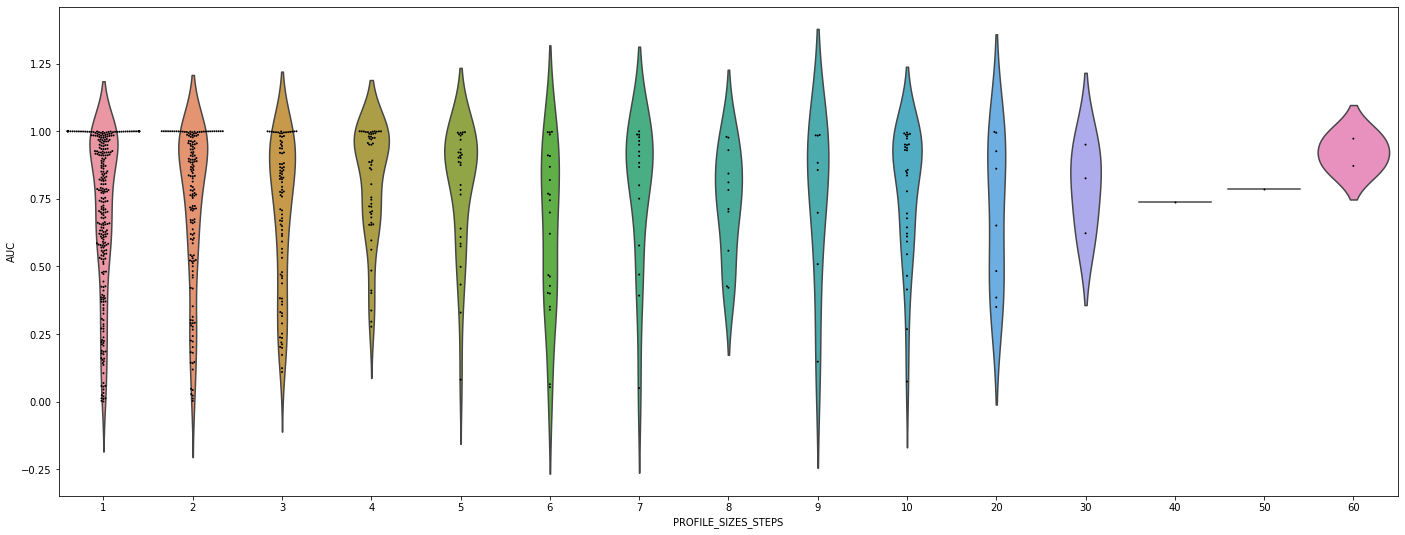

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


# Metric
METRIC = "AUC"
# Profile size range
metrics_df_plot = metrics_df.copy()
metrics_df_plot = metrics_df_plot[
    (metrics_df_plot["PROFILE_SIZES_STEPS"] >= 0) & (metrics_df_plot["PROFILE_SIZES_STEPS"] < 100)
]
# Plot METRIC distribution across users grouped by profile size
plt.figure(figsize=(24, 9))
ax = sns.violinplot(x="PROFILE_SIZES_STEPS", y=METRIC, data=metrics_df_plot, inner=None)
if DATASET != "Pinterest":
    ax = sns.swarmplot(x="PROFILE_SIZES_STEPS", y=METRIC, data=metrics_df_plot, color="black", edgecolor="gray", size=2)


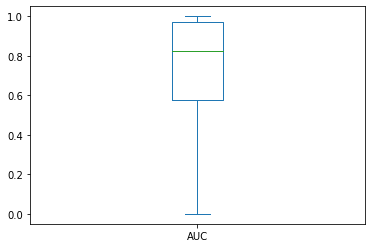

In [20]:
# Area Under the Curve distribution across users
metrics_df["AUC"].plot.box(sym="r+")
plt.show()

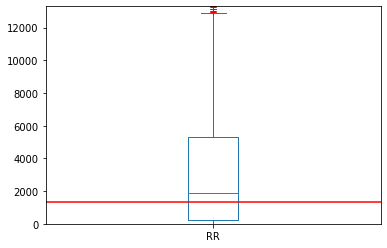

In [21]:
# First relevant item position (1 / reciprocal_rank) distribution across users
# Line marks the 10% of the dataset
graph = (1 / metrics_df["RR"]).plot.box(sym="r+")
plt.ylim(0, features.shape[0])
graph.axhline(features.shape[0] / 10, color="red")
plt.show()

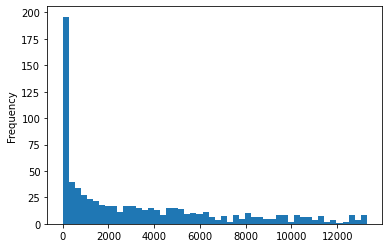

In [22]:
# First relevant item position (1 / reciprocal_rank) histogram
graph = (1 / metrics_df["RR"]).plot.hist(bins=50)

## Results inspection

In [23]:
ROW = 0

In [24]:
# Row in evaluation dataframe
row = evaluation_df.iloc[ROW]

# Load data into tensors
profile = torch.tensor(row.profile).to(device, non_blocking=True).unsqueeze(0)
user_id = torch.tensor([int(row.user_id)]).to(device, non_blocking=True)
predict = torch.tensor(row.predict).to(device, non_blocking=True)
# Prediction
if MODEL == "ACF":
    acf_profile = profile + 1
    scores = model.recommend_all(user_id, acf_profile).squeeze()
elif MODEL == 'DVBPR':
    scores = model.recommend_all(user_id, imglist, cache=cache).squeeze()
elif MODE_PROFILE == "profile":
    scores = model.recommend_all(profile)
elif MODE_PROFILE == "user":
    scores = model.recommend_all(user_id).squeeze()
# Ranking
pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()
if not PREDICT_ALL:
    pos_of_profi = (torch.argsort(scores, descending=True)[..., None] == profile).any(-1).nonzero().flatten()
    pos_of_evals -= (pos_of_profi < pos_of_evals).sum()

# Display metrics
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'Metric':^15} | {'Score':^7} |")
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'AUC':^15} | {auc_exact(pos_of_evals, N_ITEMS):.5f} |")
print(f"| {'RR':^15} | {reciprocal_rank(pos_of_evals):.5f} |")
for k in [20, 100, 500]:
    print(f"| {'-' * 15} | {'-' * 7} |")
    print(f"| {f'Recall@{k}':^15} | {recall(pos_of_evals, k):.5f} |")
    print(f"| {f'Precision@{k}':^15} | {precision(pos_of_evals, k):.5f} |")
    print(f"| {f'nDCG@{k}':^15} | {nDCG(pos_of_evals, k):.5f} |")
print(f"| {'-' * 15} | {'-' * 7} |")

# Profile and prediction
profile = profile.cpu().numpy().flatten()
predict = predict.cpu().numpy().flatten()
# Ranking
K = 20
ranking = torch.argsort(scores, descending=True).cpu().numpy().flatten()
if not PREDICT_ALL:
    ranking = ranking[(~np.isin(ranking, profile)) | (np.isin(ranking, predict))]
ranking = ranking[:K]
print()
print(f"Size of profile: {profile.size}")
print(f"Position of actual items: {pos_of_evals.cpu().numpy()}")


| --------------- | ------- |
|     Metric      |  Score  |
| --------------- | ------- |
|       AUC       | 0.84100 |
|       RR        | 0.00047 |
| --------------- | ------- |
|    Recall@20    | 0.00000 |
|  Precision@20   | 0.00000 |
|     nDCG@20     | 0.00000 |
| --------------- | ------- |
|   Recall@100    | 0.00000 |
|  Precision@100  | 0.00000 |
|    nDCG@100     | 0.00000 |
| --------------- | ------- |
|   Recall@500    | 0.00000 |
|  Precision@500  | 0.00000 |
|    nDCG@500     | 0.00000 |
| --------------- | ------- |

Size of profile: 1
Position of actual items: [2114]
